## Libraries to import

In [1]:
!pip install tensorflow
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Mounted at /content/drive


## Importing the dataset

In [3]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_30m.csv')

### Feature engineering

In [4]:
# adding features that make more sense than raw data
# all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
# all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
# all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

# all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
# all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
# all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

In [5]:
all_prices = all_prices.dropna().drop(columns=['Datetime'])

In [6]:
all_prices.head()

,Gold,Silver,CAD
0,3958.5,48.395,0.716220
1,3958.5,48.395,0.716117
2,3958.5,48.395,0.716184
3,3958.5,48.395,0.716522
4,3958.5,48.395,0.716384


In [7]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1973 entries, 0 to 1972
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gold    1973 non-null   float64
 1   Silver  1973 non-null   float64
 2   CAD     1973 non-null   float64
dtypes: float64(3)
memory usage: 46.4 KB


In [8]:
all_prices.describe()

,Gold,Silver,CAD
count,1973.000000,1973.000000,1973.000000
mean,4102.678971,50.063748,0.713069
std,102.338747,2.476129,0.002467
min,3912.000000,45.665001,0.707269
25%,4015.300049,48.180000,0.711739
50%,4084.000000,49.654999,0.713079
75%,4177.700195,51.310001,0.714643
max,4394.299805,59.195000,0.719746


In [9]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)
scaled

array([[0.09641306, 0.20177382, 0.71740044],
       [0.09641306, 0.20177382, 0.70917412],
       [0.09641306, 0.20177382, 0.7145198 ],
       ...,
       [0.6960405 , 0.90059118, 0.57467706],
       [0.69583295, 0.89504817, 0.57467706],
       [0.69894305, 0.89911323, 0.57467706]])

In [10]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [11]:
max_window = 60

X, y = create_sequences(scaled, max_window)
X.shape

(1913, 60, 3)

### Train/test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

## GRU implementation

### Hyperparameter tuning

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
def model_builder(hp):
    model = keras.Sequential([
        keras.layers.SimpleRNN(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(hp.Int("window", min_value=10, max_value=100, step=10), 3),
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg", values=[1e-6, 1e-5, 1e-4]))
        ),
        keras.layers.Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.SimpleRNN(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        ),
        keras.layers.Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.Dense(3, activation="relu") #output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),\
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_rmse", direction="min"),
    max_epochs=40,
    max_consecutive_failed_trials=5,
    seed=42,
    directory="tuning_results",
    project_name="gold_silver_cad",
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [ ]:
tuner.search(x=X_train, y=y_train, validation_split=0.15, callbacks=[stop_early])

Trial 90 Complete [00h 01m 29s]
val_rmse: 0.023131851106882095

Best val_rmse So Far: 0.018789025023579597
Total elapsed time: 00h 26m 14s


### Metrics evaluation of the best model

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_model.save('rnn_30m.keras')
best_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50, 32)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 48)             │         3,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,187 (20.26 KB)

 Trainable params: 5,187 (20.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units_1': 32,
 'window': 50,
 'l2_reg': 1e-06,
 'dropout_1': 0.15000000000000002,
 'units_2': 48,
 'l2_reg2': 1e-06,
 'dropout_2': 0.15000000000000002,
 'learning_rate': 0.005,
 'tuner/epochs': 40,
 'tuner/initial_epoch': 14,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0067'}

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model = best_model

y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
RMSE: 5.883577512477605
MAE : 2.076900896167865
MAPE: 0.0018719643082930279


In [ ]:
baseline = scaler.inverse_transform(X_test[:, -1, :])

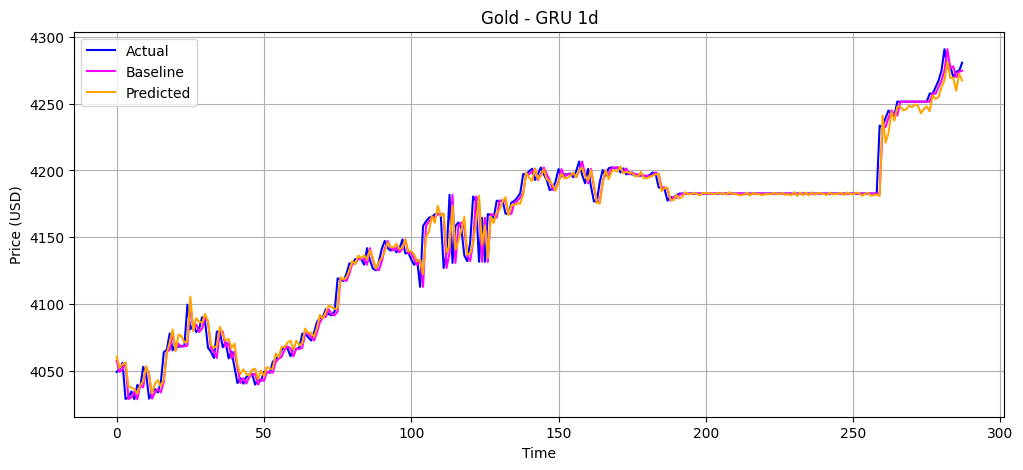

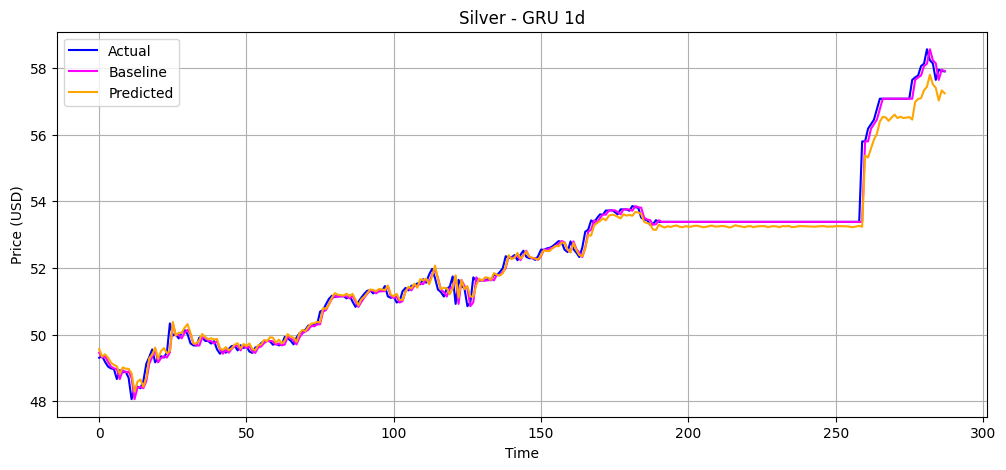

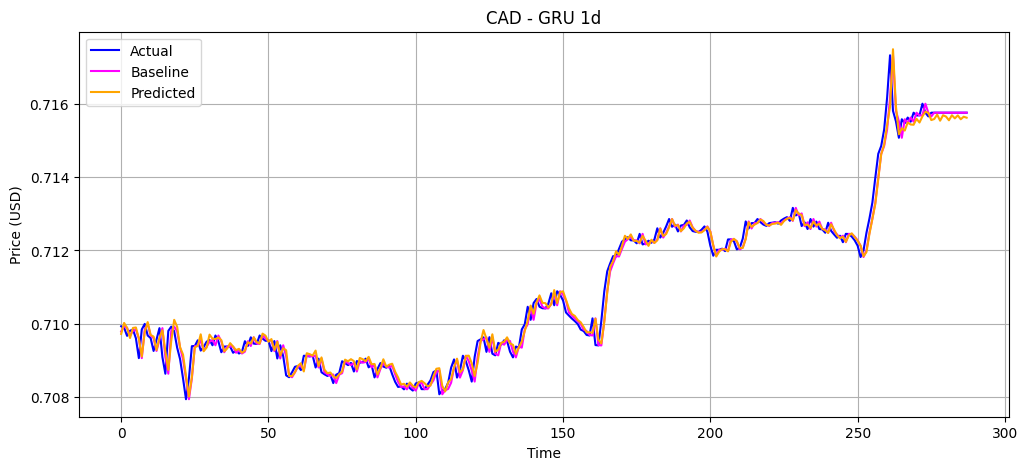

In [ ]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.title(f"{asset_name} - GRU 1d")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [ ]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 6.024369133843314
 RMSE: 10.185588674590578
 MAPE: 0.14530942012437795

Silver
 MAE : 0.20611609352959492
 RMSE: 0.32130405534277895
 MAPE: 0.385694382993607

CAD
 MAE : 0.00021746113068527647
 RMSE: 0.0003034286647973628
 MAPE: 0.030585489369923245



### Mean + std

To ensure the model did not randomly achieve good results with the test set

In [14]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
# {'units_1': 32,
#  'window': 50,
#  'l2_reg': 1e-06,
#  'dropout_1': 0.15000000000000002,
#  'units_2': 48,
#  'l2_reg2': 1e-06,
#  'dropout_2': 0.15000000000000002,
#  'learning_rate': 0.005,
#  'tuner/epochs': 40,
#  'tuner/initial_epoch': 14,
#  'tuner/bracket': 2,
#  'tuner/round': 2,
#  'tuner/trial_id': '0067'}

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mae_arr = []
rmse_arr = []
mape_arr = []

for i in range(10):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

  model = keras.Sequential([
      keras.layers.SimpleRNN(
          units=32,
          return_sequences=True,
          input_shape=(50, 3),
          kernel_regularizer=keras.regularizers.l2(1e-06)
      ),
      keras.layers.Dropout(0.15000000000000002),
      keras.layers.SimpleRNN(
          units=48,
          return_sequences=False,
          kernel_regularizer=keras.regularizers.l2(1e-6),
      ),
      keras.layers.Dropout(0.15000000000000002),
      keras.layers.Dense(3, activation="relu") #output
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(0.005),
      loss='mse',
      metrics=[rmse, mae, mape]
  )

  model.fit(X_train, y_train, epochs=40)

  y_pred = model.predict(X_test)

  y_pred_inv = scaler.inverse_transform(y_pred)
  y_test_inv = scaler.inverse_transform(y_test)

  rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
  mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
  mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

  rmse_arr.append(rmse_val)
  mae_arr.append(mae_val)
  mape_arr.append(mape_val)

  print("RMSE:", rmse_val)
  print("MAE :", mae_val)
  print("MAPE:", mape_val)

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.1099 - mae: 0.2720 - mape: 77.4853 - rmse: 0.3233
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0115 - mae: 0.0842 - mape: 70862.7891 - rmse: 0.1063
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0057 - mae: 0.0573 - mape: 28620.0938 - rmse: 0.0745
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0041 - mae: 0.0480 - mape: 271100.6250 - rmse: 0.0632
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0035 - mae: 0.0445 - mape: 91624.3203 - rmse: 0.0582
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0029 - mae: 0.0407 - mape: 224525.0156 - rmse: 0.0535
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0029 - mae: 0.0405 - mape: 518093.2500 - rmse: 0.0531
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0023 - mae: 0.0363 - mape: 192218.9062 - rmse: 0.0470
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0022 - mae: 0.0348 - mape: 222308.953

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1260 - mae: 0.2965 - mape: 87.0602 - rmse: 0.3491
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0484 - mae: 0.1723 - mape: 148986.7031 - rmse: 0.2163
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0115 - mae: 0.0833 - mape: 516769.6562 - rmse: 0.1061
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0064 - mae: 0.0606 - mape: 307571.3750 - rmse: 0.0793
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0048 - mae: 0.0532 - mape: 231883.7500 - rmse: 0.0687
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0038 - mae: 0.0461 - mape: 11270.7988 - rmse: 0.0606
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0033 - mae: 0.0434 - mape: 78330.8047 - rmse: 0.0564
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0029 - mae: 0.0402 - mape: 42082.9141 - rmse: 0.0535
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0026 - mae: 0.0387 - mape: 22407.2031

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0928 - mae: 0.2451 - mape: 25136.5234 - rmse: 0.2952
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0113 - mae: 0.0822 - mape: 443429.4375 - rmse: 0.1051
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0057 - mae: 0.0579 - mape: 191560.2031 - rmse: 0.0750
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0042 - mae: 0.0491 - mape: 388314.9375 - rmse: 0.0639
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0035 - mae: 0.0452 - mape: 168040.8906 - rmse: 0.0588
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0031 - mae: 0.0427 - mape: 301476.7500 - rmse: 0.0554
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0027 - mae: 0.0397 - mape: 360183.6875 - rmse: 0.0518
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0021 - mae: 0.0348 - mape: 34102.9922 - rmse: 0.0450
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022 - mae: 0.0347 - mape: 41571

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0977 - mae: 0.2524 - mape: 76.7501 - rmse: 0.3033
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0136 - mae: 0.0910 - mape: 675041.4375 - rmse: 0.1152
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0062 - mae: 0.0592 - mape: 84641.3984 - rmse: 0.0776
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0044 - mae: 0.0509 - mape: 155252.1250 - rmse: 0.0654
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0037 - mae: 0.0461 - mape: 1008938.6875 - rmse: 0.0604
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0029 - mae: 0.0406 - mape: 107516.6797 - rmse: 0.0532
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0027 - mae: 0.0393 - mape: 29858.8672 - rmse: 0.0513
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0024 - mae: 0.0371 - mape: 135932.1719 - rmse: 0.0486
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0022 - mae: 0.0350 - mape: 233977.5

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0973 - mae: 0.2522 - mape: 706809.6875 - rmse: 0.3018
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0135 - mae: 0.0894 - mape: 121483.7109 - rmse: 0.1148
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0058 - mae: 0.0577 - mape: 63210.2227 - rmse: 0.0754
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0045 - mae: 0.0512 - mape: 13007.4727 - rmse: 0.0668
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0037 - mae: 0.0459 - mape: 136420.6719 - rmse: 0.0605
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0029 - mae: 0.0407 - mape: 252440.4062 - rmse: 0.0528
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0027 - mae: 0.0391 - mape: 746951.6250 - rmse: 0.0512
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0026 - mae: 0.0380 - mape: 77677.5234 - rmse: 0.0498
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0023 - mae: 0.0357 - mape: 34505.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1502 - mae: 0.3215 - mape: 278159.3438 - rmse: 0.3807
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0252 - mae: 0.1250 - mape: 79342.1172 - rmse: 0.1560
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0080 - mae: 0.0691 - mape: 44289.6562 - rmse: 0.0889
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0058 - mae: 0.0576 - mape: 268825.6250 - rmse: 0.0754
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0041 - mae: 0.0486 - mape: 93429.1094 - rmse: 0.0633
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0036 - mae: 0.0460 - mape: 47991.8164 - rmse: 0.0598
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0031 - mae: 0.0429 - mape: 63802.6875 - rmse: 0.0555
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0027 - mae: 0.0394 - mape: 10524.8232 - rmse: 0.0512
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0024 - mae: 0.0364 - mape: 385646.65

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1186 - mae: 0.2861 - mape: 27890.9746 - rmse: 0.3402
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0479 - mae: 0.1705 - mape: 74772.5781 - rmse: 0.2182
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0136 - mae: 0.0899 - mape: 152620.6875 - rmse: 0.1150
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0054 - mae: 0.0560 - mape: 764761.8125 - rmse: 0.0727
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0045 - mae: 0.0518 - mape: 956534.9375 - rmse: 0.0665
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0032 - mae: 0.0427 - mape: 124205.5625 - rmse: 0.0563
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0030 - mae: 0.0416 - mape: 177712.2031 - rmse: 0.0538
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0027 - mae: 0.0392 - mape: 69515.2344 - rmse: 0.0509
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0026 - mae: 0.0384 - mape: 106429

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1388 - mae: 0.2865 - mape: 155122.9375 - rmse: 0.3450
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0344 - mae: 0.1409 - mape: 45897.4961 - rmse: 0.1805
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0086 - mae: 0.0712 - mape: 50478.7969 - rmse: 0.0918
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0054 - mae: 0.0561 - mape: 247279.7188 - rmse: 0.0728
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0041 - mae: 0.0489 - mape: 144128.6250 - rmse: 0.0631
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036 - mae: 0.0458 - mape: 272505.3438 - rmse: 0.0591
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0029 - mae: 0.0416 - mape: 14.5635 - rmse: 0.0532
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0026 - mae: 0.0389 - mape: 8149.5142 - rmse: 0.0503
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0023 - mae: 0.0362 - mape: 92766.6719 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1312 - mae: 0.2897 - mape: 85.2129 - rmse: 0.3428
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0169 - mae: 0.0996 - mape: 188838.5156 - rmse: 0.1276
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0071 - mae: 0.0647 - mape: 303449.7500 - rmse: 0.0832
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0050 - mae: 0.0539 - mape: 1014421.3750 - rmse: 0.0698
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0039 - mae: 0.0474 - mape: 89274.2500 - rmse: 0.0618
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0030 - mae: 0.0419 - mape: 368835.8125 - rmse: 0.0547
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0030 - mae: 0.0418 - mape: 85614.5703 - rmse: 0.0539
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025 - mae: 0.0377 - mape: 223871.1406 - rmse: 0.0489
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0023 - mae: 0.0363 - mape: 576536.3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1440 - mae: 0.2996 - mape: 86.0645 - rmse: 0.3551
Epoch 2/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0184 - mae: 0.1049 - mape: 65374.5508 - rmse: 0.1340
Epoch 3/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0084 - mae: 0.0694 - mape: 78333.2109 - rmse: 0.0907
Epoch 4/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0054 - mae: 0.0552 - mape: 115475.4922 - rmse: 0.0729
Epoch 5/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0044 - mae: 0.0502 - mape: 161640.8281 - rmse: 0.0653
Epoch 6/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0040 - mae: 0.0478 - mape: 124540.0469 - rmse: 0.0622
Epoch 7/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0030 - mae: 0.0413 - mape: 150621.5156 - rmse: 0.0544
Epoch 8/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0026 - mae: 0.0385 - mape: 171051.0000 - rmse: 0.0505
Epoch 9/40
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0023 - mae: 0.0366 - mape: 63306.726

In [ ]:
mae_arr = np.array(mae_arr)
rmse_arr = np.array(rmse_arr)
mape_arr = np.array(mape_arr)

print("RMSE: mean =", np.mean(rmse_arr), '|| std dev =', np.std(rmse_arr))
print("MAE : mean =", np.mean(mae_arr), '|| std dev =', np.std(mae_arr))
print("MAPE: mean =", np.mean(mape_arr), '|| std dev =', np.std(mape_arr))

RMSE: mean = 7.411750749965965 || std dev = 1.4389025709435521
MAE : mean = 3.3619574937210586 || std dev = 0.9134599995094805
MAPE: mean = 0.0022963694416314505 || std dev = 0.0003521805851687021


### Final model

Model trained on all the dataset set to be used for future predictions

In [15]:
model = keras.Sequential([
    keras.layers.SimpleRNN(
        units=32,
        return_sequences=True,
        input_shape=(50, 3),
        kernel_regularizer=keras.regularizers.l2(1e-06)
    ),
    keras.layers.Dropout(0.15000000000000002),
    keras.layers.SimpleRNN(
        units=48,
        return_sequences=False,
        kernel_regularizer=keras.regularizers.l2(1e-6),
    ),
    keras.layers.Dropout(0.15000000000000002),
    keras.layers.Dense(3, activation="relu") #output
])

model.compile(
    optimizer=keras.optimizers.Adam(0.005),
    loss='mse',
    metrics=[rmse, mae, mape]
)

model.fit(X, y, epochs=40)

Epoch 1/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.1341 - mae: 0.3018 - mape: 1133540.0000 - rmse: 0.3615
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0256 - mae: 0.1254 - mape: 207563.7812 - rmse: 0.1572
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0084 - mae: 0.0692 - mape: 438106.8125 - rmse: 0.0902
Epoch 4/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0050 - mae: 0.0539 - mape: 40859.1953 - rmse: 0.0701
Epoch 5/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0036 - mae: 0.0455 - mape: 174254.6094 - rmse: 0.0593
Epoch 6/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0033 - mae: 0.0432 - mape: 68028.4219 - rmse: 0.0565
Epoch 7/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0029 - mae: 0.0401 - mape: 433063.0312 - rmse: 0.0531
Epoch 8/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0026 - mae: 0.0381 - mape: 17282.7656 - rmse: 0.0500
Epoch 9/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0024 - mae: 0.0364 -

In [16]:
model.save('rnn_30m.keras')